# CIFAR-10
### Fed-Avg and FML Proxy using LeNet and CNN on CIFAR-10 dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
import seaborn as sns

In [ ]:
# Configs
NUM_CLIENTS = 5
NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Transforms for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [ ]:
# Load CIFAR-10 and split into train/validation/test
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


In [ ]:
# Split train dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# CNN Model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(576, 84), nn.ReLU(),  # Corrected: 16*6*6 = 576
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Dataset Split
def split_dataset(dataset, num_clients):
    size = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    return [Subset(dataset, indices[i * size:(i + 1) * size]) for i in range(num_clients)]

client_datasets = split_dataset(train_dataset, NUM_CLIENTS)

In [ ]:
# Metrics Tracking
def compute_metrics(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss += F.cross_entropy(preds, y, reduction='sum').item()
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(F.softmax(preds, dim=1).cpu().numpy())

    accuracy = 100. * correct / total
    avg_loss = loss / total
    return accuracy, avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [ ]:
# Plotting Functions
def plot_metrics(train_metrics, val_metrics, test_metrics, model_name, method):
    epochs = range(1, NUM_EPOCHS + 1)

    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics['acc'], label='Train Accuracy')
    plt.plot(epochs, val_metrics['acc'], label='Validation Accuracy')
    plt.plot(epochs, test_metrics['acc'], label='Test Accuracy')
    plt.title(f'{model_name} {method} Accuracy (CIFAR-10)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_accuracy_cifar10.png')
    plt.close()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics['loss'], label='Train Loss')
    plt.plot(epochs, val_metrics['loss'], label='Validation Loss')
    plt.plot(epochs, test_metrics['loss'], label='Test Loss')
    plt.title(f'{model_name} {method} Loss (CIFAR-10)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_loss_cifar10.png')
    plt.close()

def plot_roc_curve(labels, probs, model_name, method):
    plt.figure(figsize=(10, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'cyan', 'magenta', 'yellow', 'lime', 'red'])

    for i in range(10):
        fpr, tpr, _ = roc_curve(labels == i, probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=next(colors), lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} {method} ROC Curve (CIFAR-10)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_roc_cifar10.png')
    plt.close()

def plot_confusion_matrix(labels, preds, model_name, method):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} {method} Confusion Matrix (CIFAR-10)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_{method}_cm_cifar10.png')
    plt.close()

In [ ]:
# FedAvg Training
def fedavg_train(model_class, model_name):
    global_model = model_class().to(DEVICE)
    print(f"\n🔁 Training FedAvg with {model_name} on CIFAR-10")

    train_metrics = {'acc': [], 'loss': []}
    val_metrics = {'acc': [], 'loss': []}
    test_metrics = {'acc': [], 'loss': []}

    for epoch in range(NUM_EPOCHS):
        local_weights = []
        for client_data in client_datasets:
            model = copy.deepcopy(global_model)
            model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            loader = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)
            model.train()
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                preds = model(x)
                loss = F.cross_entropy(preds, y)
                loss.backward()
                optimizer.step()
            local_weights.append(copy.deepcopy(model.state_dict()))

        global_model.load_state_dict(average_weights(local_weights))

        # Compute metrics
        train_acc, train_loss, _, _, _ = compute_metrics(global_model, train_loader)
        val_acc, val_loss, _, _, _ = compute_metrics(global_model, val_loader)
        test_acc, test_loss, labels, preds, probs = compute_metrics(global_model, test_loader)

        train_metrics['acc'].append(train_acc)
        train_metrics['loss'].append(train_loss)
        val_metrics['acc'].append(val_acc)
        val_metrics['loss'].append(val_loss)
        test_metrics['acc'].append(test_acc)
        test_metrics['loss'].append(test_loss)

        print(f"Epoch {epoch+1}, FedAvg {model_name} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        # Plot ROC and Confusion Matrix for final epoch
        if epoch == NUM_EPOCHS - 1:
            plot_roc_curve(labels, probs, model_name, 'FedAvg')
            plot_confusion_matrix(labels, preds, model_name, 'FedAvg')

    plot_metrics(train_metrics, val_metrics, test_metrics, model_name, 'FedAvg')
    return global_model, test_metrics['acc'][-1]


In [ ]:
# FML-Proxy Training
def fml_proxy_train(model_class, model_name):
    print(f"\n🔁 Training FML-Proxy with {model_name} on CIFAR-10")
    priv_models = [model_class().to(DEVICE) for _ in range(NUM_CLIENTS)]
    proxy_models = [model_class().to(DEVICE) for _ in range(NUM_CLIENTS)]

    train_metrics = {'acc': [], 'loss': []}
    val_metrics = {'acc': [], 'loss': []}
    test_metrics = {'acc': [], 'loss': []}

    for epoch in range(NUM_EPOCHS):
        for i in range(NUM_CLIENTS):
            client_data = client_datasets[i]
            priv = priv_models[i]
            proxy = proxy_models[i]

            priv.train()
            proxy.train()

            priv_opt = torch.optim.Adam(priv.parameters(), lr=LEARNING_RATE)
            proxy_opt = torch.optim.Adam(proxy.parameters(), lr=LEARNING_RATE)
            loader = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)

            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                # Proxy update using ensemble
                with torch.no_grad():
                    ensemble = torch.zeros(x.size(0), 10).to(DEVICE)
                    for j, other in enumerate(priv_models):
                        if j != i:
                            other.eval()
                            ensemble += F.softmax(other(x), dim=1)
                    ensemble /= (NUM_CLIENTS - 1)

                proxy_logits = proxy(x)
                loss_proxy = F.kl_div(F.log_softmax(proxy_logits, dim=1), ensemble, reduction='batchmean')
                proxy_opt.zero_grad()
                loss_proxy.backward()
                proxy_opt.step()

                # Private update using proxy + true labels
                priv_logits = priv(x)
                with torch.no_grad():
                    proxy_logits = proxy(x)

                loss_kd = F.kl_div(F.log_softmax(priv_logits, dim=1),
                                 F.softmax(proxy_logits, dim=1), reduction='batchmean')
                loss_ce = F.cross_entropy(priv_logits, y)
                loss = 0.7 * loss_kd + 0.3 * loss_ce

                priv_opt.zero_grad()
                loss.backward()
                priv_opt.step()

        # Compute average metrics across clients
        train_accs, train_losses = [], []
        val_accs, val_losses = [], []
        test_accs, test_losses = [], []
        all_labels, all_preds, all_probs = [], [], []

        for priv in priv_models:
            train_acc, train_loss, _, _, _ = compute_metrics(priv, train_loader)
            val_acc, val_loss, _, _, _ = compute_metrics(priv, val_loader)
            test_acc, test_loss, labels, preds, probs = compute_metrics(priv, test_loader)

            train_accs.append(train_acc)
            train_losses.append(train_loss)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

        train_metrics['acc'].append(np.mean(train_accs))
        train_metrics['loss'].append(np.mean(train_losses))
        val_metrics['acc'].append(np.mean(val_accs))
        val_metrics['loss'].append(np.mean(val_losses))
        test_metrics['acc'].append(np.mean(test_accs))
        test_metrics['loss'].append(np.mean(test_losses))

        print(f"Epoch {epoch+1}, FML-Proxy {model_name} - Train Acc: {np.mean(train_accs):.2f}%, Val Acc: {np.mean(val_accs):.2f}%, Test Acc: {np.mean(test_accs):.2f}%")

        # Plot ROC and Confusion Matrix for final epoch
        if epoch == NUM_EPOCHS - 1:
            plot_roc_curve(np.array(all_labels), np.array(all_probs), model_name, 'FML-Proxy')
            plot_confusion_matrix(np.array(all_labels), np.array(all_preds), model_name, 'FML-Proxy')

    plot_metrics(train_metrics, val_metrics, test_metrics, model_name, 'FML-Proxy')
    return priv_models, np.mean(test_accs)


In [ ]:
# FedAvg Aggregation
def average_weights(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for k in avg.keys():
        for i in range(1, len(state_dicts)):
            avg[k] += state_dicts[i][k]
        avg[k] = avg[k] / len(state_dicts)
    return avg


In [ ]:
# Train and Compare
def compare_models():
    print("\n🚀 Training and Comparing CNN and LeNet on CIFAR-10")

    # Train CNN
    cnn_fed_model, cnn_fed_acc = fedavg_train(CNN, "CNN")
    cnn_fml_models, cnn_fml_acc = fml_proxy_train(CNN, "CNN")

    # Train LeNet
    lenet_fed_model, lenet_fed_acc = fedavg_train(LeNet, "LeNet")
    lenet_fml_models, lenet_fml_acc = fml_proxy_train(LeNet, "LeNet")

    # Comparison
    print(f"\n✅ Final Results:")
    print(f"CNN FedAvg Test Accuracy: {cnn_fed_acc:.2f}%")
    print(f"CNN FML-Proxy Average Test Accuracy: {cnn_fml_acc:.2f}%")
    print(f"LeNet FedAvg Test Accuracy: {lenet_fed_acc:.2f}%")
    print(f"LeNet FML-Proxy Average Test Accuracy: {lenet_fml_acc:.2f}%")

    # Bar Plot for Comparison
    models = ['CNN FedAvg', 'CNN FML-Proxy', 'LeNet FedAvg', 'LeNet FML-Proxy']
    accuracies = [cnn_fed_acc, cnn_fml_acc, lenet_fed_acc, lenet_fml_acc]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=accuracies)
    plt.title('Model Comparison - Test Accuracy (CIFAR-10)')
    plt.ylabel('Test Accuracy (%)')
    plt.xticks(rotation=45)
    plt.savefig('model_comparison_cifar10.png')
    plt.close()

In [ ]:
# Run the comparison
compare_models()


🚀 Training and Comparing CNN and LeNet on CIFAR-10

🔁 Training FedAvg with CNN on CIFAR-10
Epoch 1, FedAvg CNN - Train Acc: 41.60%, Val Acc: 41.89%, Test Acc: 41.83%
Epoch 2, FedAvg CNN - Train Acc: 52.44%, Val Acc: 52.39%, Test Acc: 52.41%
Epoch 3, FedAvg CNN - Train Acc: 57.83%, Val Acc: 56.75%, Test Acc: 57.19%
Epoch 4, FedAvg CNN - Train Acc: 62.09%, Val Acc: 60.93%, Test Acc: 60.87%
Epoch 5, FedAvg CNN - Train Acc: 65.98%, Val Acc: 63.78%, Test Acc: 63.41%
Epoch 6, FedAvg CNN - Train Acc: 68.83%, Val Acc: 66.55%, Test Acc: 66.38%
Epoch 7, FedAvg CNN - Train Acc: 71.22%, Val Acc: 68.32%, Test Acc: 67.59%
Epoch 8, FedAvg CNN - Train Acc: 72.52%, Val Acc: 68.71%, Test Acc: 68.37%
Epoch 9, FedAvg CNN - Train Acc: 75.00%, Val Acc: 70.51%, Test Acc: 69.95%
Epoch 10, FedAvg CNN - Train Acc: 76.83%, Val Acc: 72.05%, Test Acc: 71.17%
Epoch 11, FedAvg CNN - Train Acc: 78.24%, Val Acc: 72.67%, Test Acc: 71.82%
Epoch 12, FedAvg CNN - Train Acc: 79.71%, Val Acc: 72.87%, Test Acc: 72.86%
Epoch

Displaying: CNN_FedAvg_accuracy_cifar10.png


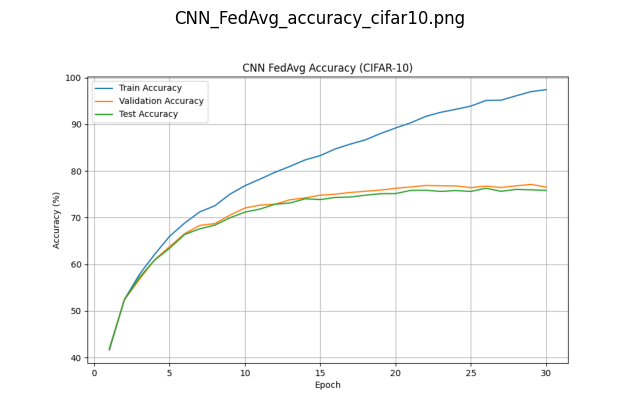

Displaying: CNN_FedAvg_loss_cifar10.png


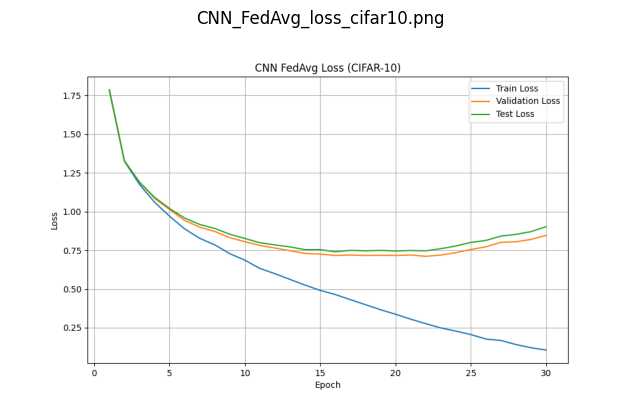

Displaying: CNN_FedAvg_roc_cifar10.png


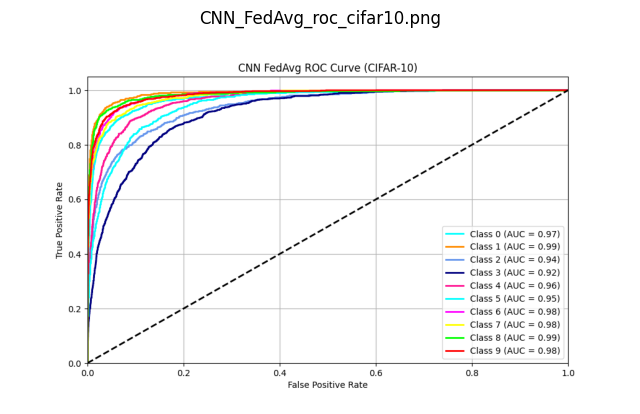

Displaying: CNN_FedAvg_cm_cifar10.png


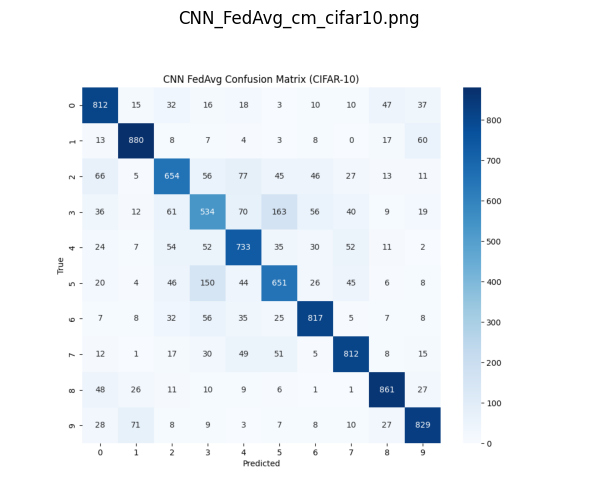

Displaying: CNN_FML-Proxy_accuracy_cifar10.png


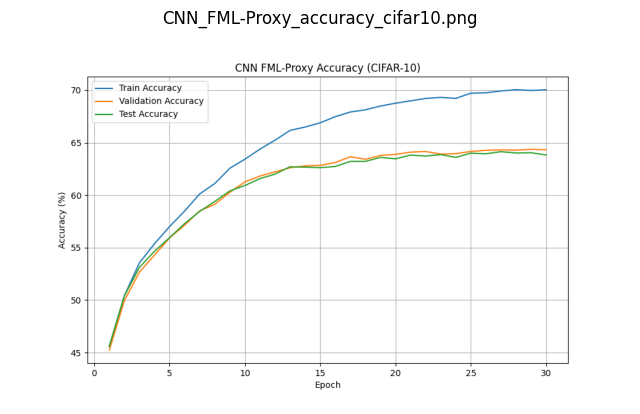

Displaying: CNN_FML-Proxy_loss_cifar10.png


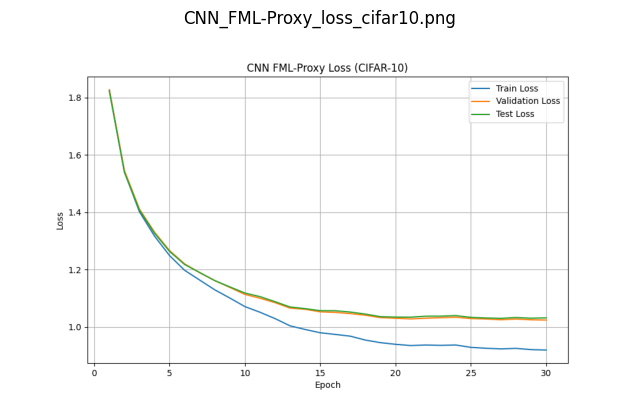

Displaying: CNN_FML-Proxy_roc_cifar10.png


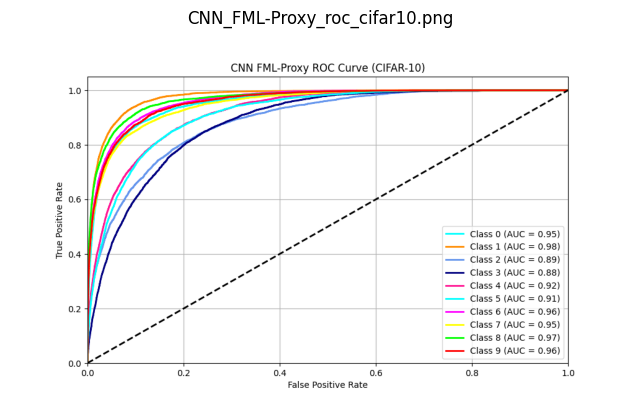

Displaying: CNN_FML-Proxy_cm_cifar10.png


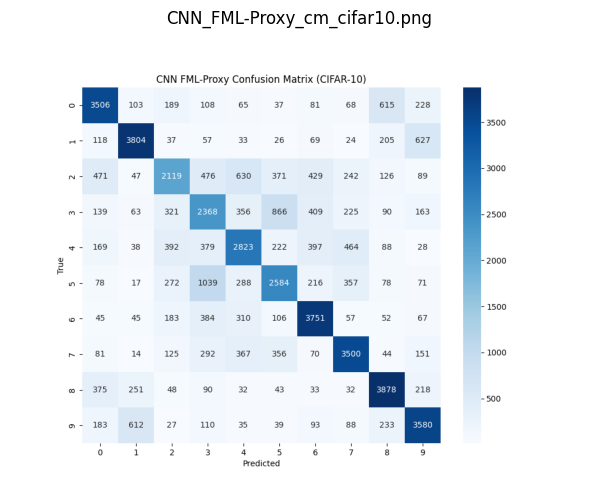

Displaying: LeNet_FedAvg_accuracy_cifar10.png


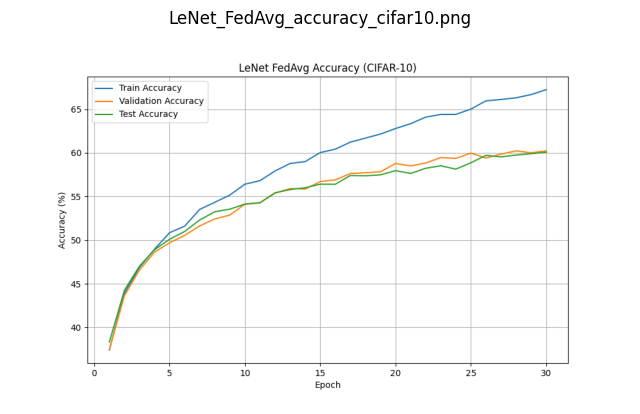

Displaying: LeNet_FedAvg_loss_cifar10.png


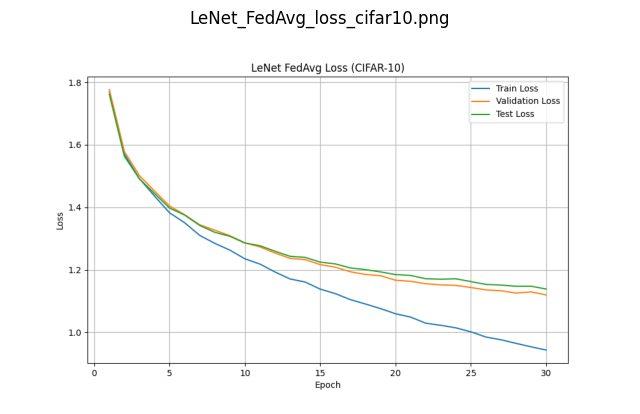

Displaying: LeNet_FedAvg_roc_cifar10.png


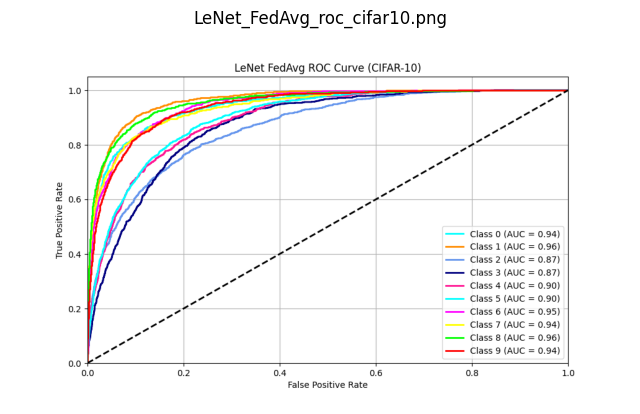

Displaying: LeNet_FedAvg_cm_cifar10.png


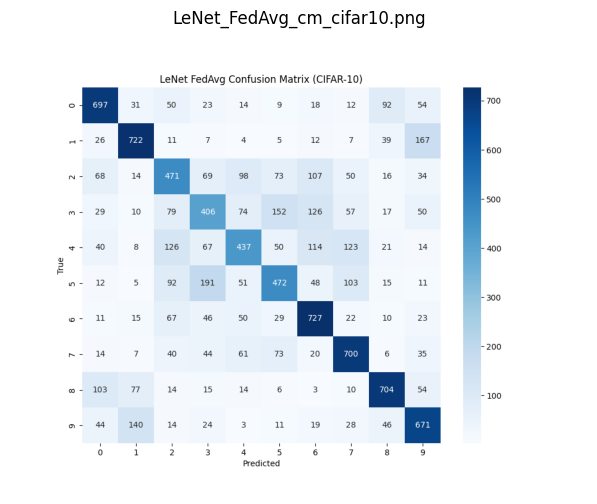

Displaying: LeNet_FML-Proxy_accuracy_cifar10.png


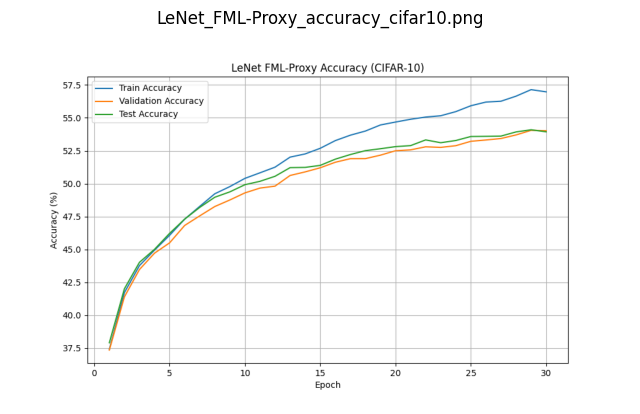

Displaying: LeNet_FML-Proxy_loss_cifar10.png


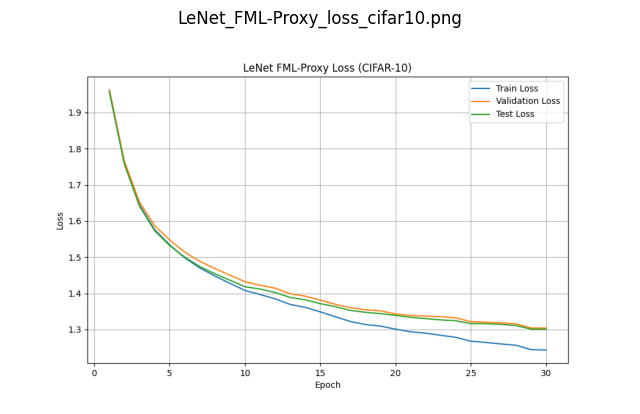

Displaying: LeNet_FML-Proxy_roc_cifar10.png


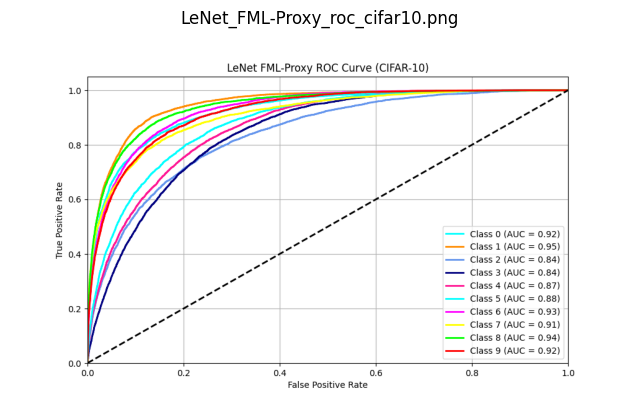

Displaying: LeNet_FML-Proxy_cm_cifar10.png


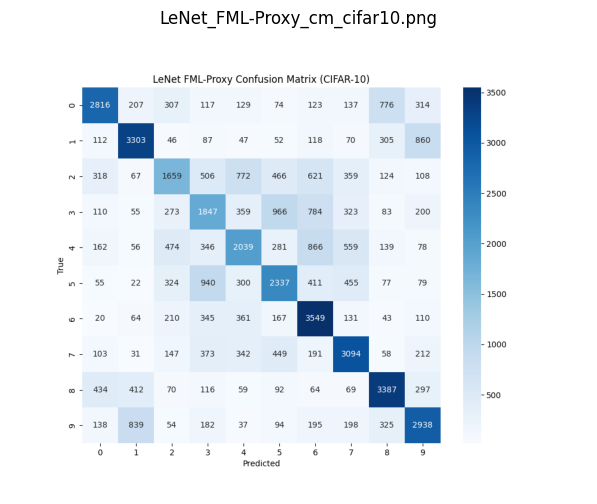

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_plots(dataset='cifar10'):
    # Define models and methods
    models = ['CNN', 'LeNet']
    methods = ['FedAvg', 'FML-Proxy']
    metrics = ['accuracy', 'loss', 'roc', 'cm']  # Adjust metrics based on your code
    datast = 'cifar10'

    # Directory where plots are saved
    plot_dir = '/content'  # Update if plots are saved elsewhere (e.g., './plots/')

    # Loop through all combinations
    for model in models:
        for method in methods:
            for metric in metrics:
                # Construct plot filename based on your naming convention
                plot_file = f"{model}_{method}_{metric}_{datast}.png"
                plot_path = os.path.join(plot_dir, plot_file)

                # Check if the plot exists
                if os.path.exists(plot_path):
                    print(f"Displaying: {plot_file}")
                    # Load and display the image
                    img = Image.open(plot_path)
                    plt.figure(figsize=(8, 6))
                    plt.imshow(img)
                    plt.axis('off')  # Hide axes
                    plt.title(plot_file)
                    plt.show()
                else:
                    print(f"Plot not found: {plot_file}")

# Call the function to display MNIST plots
display_plots(dataset='cifar10')